In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep  5 11:23:27 2024

@author: Wstev
"""

import matplotlib.pyplot as plt
import numpy as np
from nexusformat.nexus import nxload
print("ALL GOOD HERE BOSS!")

ALL GOOD HERE BOSS!


In [2]:
class Nexus_handling:
    def get_nexus_data_I06(self,file):
        """Function that loads the data from a nexus file and returns it as a list of numpy
arrays"""
        entry_string = "entry"
        data_region_list = []
        metadata_region_list = None
        x_array = file[entry_string]["instrument"]["fastEnergy"]["value"].nxvalue
        y_array = file[entry_string]["instrument"]["fesData"]["C1"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["C5"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["idio"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["ifiofb"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        magnet_field = file[entry_string]["instrument"]["scm"]["field_z"].nxvalue
        metadata_region_list = {"magnet_ﬁeld": magnet_field}
        polar = file[entry_string]["instrument"]["id"]["polarisation"].nxvalue
        metadata_region_list["polarisation"] = polar
        return data_region_list, metadata_region_list

    def open_single_spectra(self,ﬁle_number,directory_path,ﬁle_preﬁx,sensor):
        ﬁle_name = directory_path + ﬁle_preﬁx + str(ﬁle_number) + ".nxs"
        spectra_ﬁle = nxload(ﬁle_name)
        data,meta_data = self.get_nexus_data_I06(spectra_ﬁle)
        if sensor == "TEY":
            spectra = {"x" : data[2]["x"],"y":data[2]["y"],"meta" : meta_data}
        elif sensor == "TFY":
            spectra = {"x" : data[3]["x"],"y":data[3]["y"],"meta" : meta_data}
        return spectra

    def group_spectra(self,XMCD_spectra_id):
        grouped_data = []
        for i in range(XMCD_spectra_id, XMCD_spectra_id+self.group_size):
            x,y = self.open_single_spectra(i,self.directory_path,self.ﬁle_preﬁx)
            data_set = np.array([x,y])
            grouped_data.append(data_set)
        return grouped_data

print("No Errors here")

No Errors here


In [3]:
class normalisation_procedures:

    def normalise_spectra_vy_oI_edge_point(spectra_set,oI_edge = 542):
        """Norm procedure by an of single point from the oI edge"""
        normalised_set = []
        for i in range(len(spectra_set)):
            x = spectra_set[i][0]
            y = spectra_set[i][1]
        #get y value at index closest to where x = oI_edge
            y_oI_edge = y[np.argmin(np.abs(x-oI_edge))]
            y = y/y_oI_edge
            normalised_set.append(np.array([x,y]))
        return normalised_set

    def normalise_spectra_by_range(self,spectra_set,oI_edge_range = [570,573]):  
        """Norm procedure by an of range along the oI edge"""
        x = spectra_set["x"]
        y = spectra_set["y"]
        #get y value at index closest to where x = oI_edge
        y_oI_edge = np.mean(y[np.where((x > oI_edge_range[0]) & (x < oI_edge_range[1]))])
        return y - y_oI_edge
        
    def normalise_spectra_by_linear_ﬁt(spectra_set,oI_edge_range = [570,573]):
        """Norm procedure by ﬁtting a line to the oI edfe"""
        normalised_set = []
        for i in range(len(spectra_set)):
            x = spectra_set[i][0]
            y = spectra_set[i][1]
        #get y value at index closest to where x = oI_edge
            y_oI_edge = y[np.where((x > oI_edge_range[0]) & (x < oI_edge_range[1]))]
            x_oI_edge = x[np.where((x > oI_edge_range[0]) & (x < oI_edge_range[1]))] #ﬁt a line to the oI edge
            def line(x,m,c):
                return m*x + c
            model = lm.Model(line)
            params = model.make_params(m=0,c=0)
            result = model.ﬁt(y_oI_edge,params,x=x_oI_edge)
            y = y - result.best_ﬁt
            normalised_set.append(np.array([x_oI_edge,y]))
        return normalised_set

    def _calculate_shirley_background_full_range(xps: np.ndarray, eps=1e-7, max_iters=50, n_samples=5)-> np.ndarray:
        """Core routine for calculating a Shirley background on np.ndarray data."""
        background = np.copy(xps)
        cumulative_xps = np.cumsum(xps, axis=0)
        total_xps = np.sum(xps, axis=0)
       
        rel_error = np.inf
       
        i_left = np.mean(xps[:n_samples], axis=0)
        i_right = np.mean(xps[-n_samples:], axis=0)
       
        iter_count = 0
       
        k = i_left - i_right
        for iter_count in range(max_iters):
            cumulative_background = np.cumsum(background, axis=0)
            total_background = np.sum(background, axis=0)
         
            new_bkg = np.copy(background)
       
        for i in range(len(new_bkg)):
            new_bkg[i] = i_right + k * ((total_xps - cumulative_xps[i] - (total_background - cumulative_background[i]))/(total_xps - total_background + 1e-5))
       
            rel_error = np.abs(np.sum(new_bkg, axis=0) - total_background) / (total_background)
       
            background = new_bkg
            if np.any(rel_error < eps): break
            #if (iter_count + 1) == max_iters:
                #warnings.warn("Shirley background calculation did not converge " + "after {} steps with relative error {}!".format(max_iters, rel_error))
        return background

print("A significant lack of problems in the vicinity")
    

A significant lack of problems in the vicinity


In [4]:
class XMCD_data_analysis(Nexus_handling):
    def init(self):
        self.on_oI_edge_points = [571, 576.9]
        self.directory_path = None
        self.ﬁle_preﬁx = None
        self.energy = None
        self.spectra = []
        self.hyst = []
        self.XMCD = []
        self.magz = []


    def set_directory_path(self, directory_path):
        self.directory_path = directory_path

    def set_ﬁle_preﬁx(self, ﬁle_preﬁx):
        self.ﬁle_preﬁx = ﬁle_preﬁx

    def load_spectra(self, directory_path, ﬁle_preﬁx, XMCD_spectra_Set,sensor = "TEY"):  
        self.directory_path = directory_path
        self.ﬁle_preﬁx = ﬁle_preﬁx
 
        for ﬁle_number in XMCD_spectra_Set: #
            print(ﬁle_number)
            data_set = self.open_single_spectra(ﬁle_number, directory_path,  ﬁle_preﬁx,sensor)
            self.spectra.append(data_set)
            self.energy = self.spectra[0]["x"]


    def  normalise_all_spectra(self,  procedure="normalise_spectra_by_linear_ﬁt",  oI_edge=  [570, 573]):
        for i in range(len(self.spectra)):
            y = getattr(normalisation_procedures, procedure)(self, self.spectra[i], oI_edge)
            y = y - normalisation_procedures._calculate_shirley_background_full_range(y)
            self.spectra[i]["y"] = y

    def check_spectra(self,start = 0,ﬁnish = 20, group_size = 5):
        for i in range(start,ﬁnish,group_size):
            for j in range(group_size):
                x = self.spectra[i+j]["x"]
                y = self.spectra[i+j]["y"]
                back  =  normalisation_procedures._calculate_shirley_background_full_range(y)  
                ﬁg,ax = plt.subplots()
                plt.plot(x,y)
                plt.plot(x,back)
                ax.annotate(str(self.spectra[i+j]["meta"]["magnet_ﬁeld"]),xy=(0.9,0.9),xytext  =  (0.95,0.95),xycoords = "axes fraction")
            plt.show()
        return

    def decimal_length(number):
        # Convert the number to a string
        number_str = str(number)

    # Find the position of the decimal point
        decimal_position = number_str.ﬁnd('.')

    # If there's no decimal point, return 0
        if decimal_position == -1:
            return 0


    def plotXAS(self,XMCD_ﬁle_Set,fig,axs):
        self.normalise_all_spectra(procedure="normalise_spectra_by_range",  oI_edge=  [570, 573])
            #takes in a 2x2 axis
        plt.rcParams.update({'font.size': 14})
        F = self.energy
        axs[1].set_title(("XAS ",sensor,"(normalised)"))
        axs[0].set_title(("XAS ",sensor))
        axs[0].set_xlabel("Energy(eV)")
        axs[0].set_ylabel("idio")
        axs[1].set_xlabel("Energy(eV)")
           
        plt.rcParams.update({'font.size': 12})
        for i in range(0,len(XMCD_file_Set)):
            a = self.spectra[i]
            F = a["y"]
            B = a["x"]
            print("F:", F)
            print("B:", B)
            #plt.pause(0.5)
            axs[0].plot(B,(F),label = str(XMCD_file_Set[i]))
            axs[1].plot(B,(F)/np.max(F),label = str(XMCD_file_Set[i]))
        axs[0].legend(loc="best") 
        plot_numbers = [B, F, F/np.max(F)]
        return plot_numbers





print("All good once again")

All good once again


328342
328348
F: [-8.600043e-03 -8.560443e-03 -8.581159e-03 ... -4.369314e-05 -1.344040e-04
 -2.225249e-04]
B: [569.9563 570.0395 570.128  ... 594.796  594.8956 594.9982]
F: [-2.366758e-03 -2.440030e-03 -2.483882e-03 ... -2.555239e-05 -3.559517e-05
 -1.101452e-04]
B: [569.9599 570.042  570.1253 ... 594.8023 594.9015 594.9951]


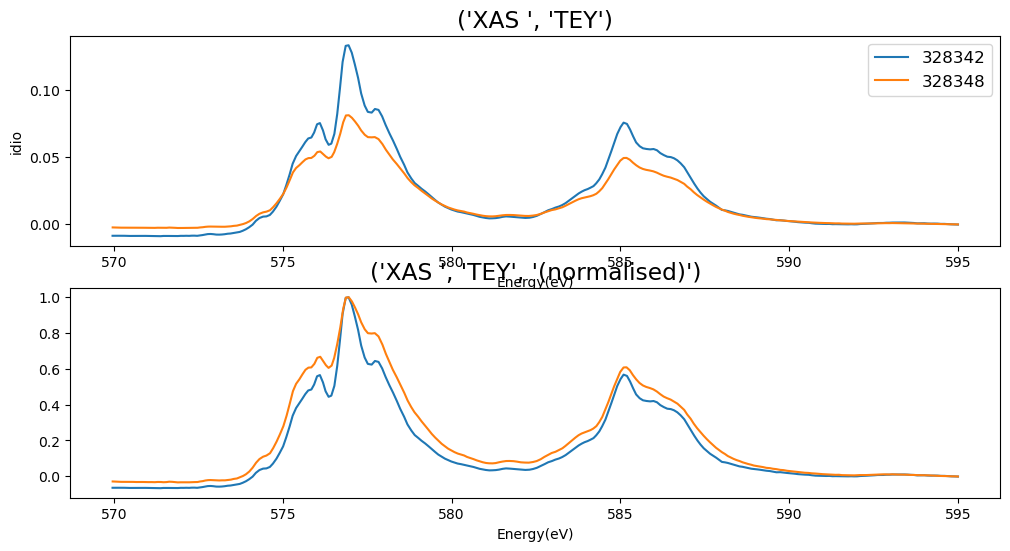

In [5]:
#%%
#% Write XAS - idio,fluroscense,then both normalised
# XAS on BP(1)
directory_path = ""
ﬁle_preﬁx = "i06-1-"

#fig, axs = plt.subplots(2,3, figsize=(12, 6))
sensor = "TEY" ### Can be TEY or TFY
#XMCD_ﬁle_Set=(328342,328348,328343,328344,328345,328346,328347,328349,328459,328451,328554,328555,328556,328557,328558,328559,328930,328971,328972,328973,328976,328977,328978,328979,328983,328984,328985,328986,328987,328988,328989,328990,328992,328993,329003,329006,329007,329010)
#XMCD_ﬁle_Set=(328342,328343,328344,328345,328346,328347,328348,328349,328451,328554,328556,328556,328557,328558,328559,328930,328971,328973,328976,328977,328978,328979,328983,328984,328985,328986,328987,328989,328992,328993,329003,329006,329007,329010)

files = [328342, 328348, 328343,328344]
files = [328342,328348]
XMCD = XMCD_data_analysis()
XMCD.init()
XMCD.load_spectra(directory_path, ﬁle_preﬁx, files,sensor)
fig, axs = plt.subplots(2,figsize=(12, 6))
B, F, F_norm = XMCD.plotXAS(files,fig,axs)


